In [42]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import groupby
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import nltk
import lightgbm as lgb

from utils import helper
from utils import DataLoader, DataProcesser
from utils import TimeKeeper

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
label_dic = {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike', 5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

# Routine PipLines

In [87]:
col_drop_x = ['time', 'label']
col_label = 'label'
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed'
 ]

In [88]:
data = DataLoader.SHLDataLoader('data/train/', ratio = None)
val = DataLoader.SHLDataLoader('data/validate/', ratio = None)
data.df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val.df = pd.read_csv('data/mid_res/20210526_val_df.csv')

In [89]:
# tmp modeul
data.df['have_loc'] = data.df.apply(lambda x: 1 if x['accuracy'] > -1 else 0, axis = 1)
data.df['have_gps'] = data.df.apply(lambda x: 1 if x['num_gps'] > 0 else 0, axis = 1)
data.df['have_wifi'] = data.df.apply(lambda x: 1 if x['num_wifi'] > 0 else 0, axis = 1)
data.df['have_cells'] = data.df.apply(lambda x: 1 if x['num_cells'] > 0 else 0, axis = 1)

val.df['have_loc'] = val.df.apply(lambda x: 1 if x['accuracy'] > -1 else 0, axis = 1)
val.df['have_gps'] = val.df.apply(lambda x: 1 if x['num_gps'] > 0 else 0, axis = 1)
val.df['have_wifi'] = val.df.apply(lambda x: 1 if x['num_wifi'] > 0 else 0, axis = 1)
val.df['have_cells'] = val.df.apply(lambda x: 1 if x['num_cells'] > 0 else 0, axis = 1)

In [90]:
test_ratio = 0.2
col_label = 'label'
X = data.df.drop(col_drop + col_drop_x, axis = 1).fillna(0)
# X_train, X_test, y_train, y_test = train_test_split(X, data.df[col_label], test_size = test_ratio)
X_train, y_train = X, data.df[col_label]
X_val, y_val = val.df.drop(col_drop + col_drop_x, axis = 1).fillna(0), val.df[col_label]

In [91]:
X_train.shape

(980527, 36)

In [92]:
# X_val, y_val = X_test, y_test

In [93]:
timer = TimeKeeper.TimeKeeper()
model_rf = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_val)
pred_prob_rf = model_rf.predict_proba(X_val)
print(timer.get_update_time())

25.07


In [94]:
timer = TimeKeeper.TimeKeeper()
model_bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100, max_samples = 100, bootstrap=True)
model_bag.fit(X_train, y_train)
pred_bag = model_bag.predict(X_val)
pred_prob_bag = model_bag.predict_proba(X_val)
print(timer.get_update_time())

37.38


In [95]:
train_data = lgb.Dataset(X_train, label = y_train - 1)
test_data = lgb.Dataset(X_val, label = y_val - 1)
params={
    'learning_rate':0.1,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':6,
    'objective':'multiclass',
    'num_class':8,  
}

timer = TimeKeeper.TimeKeeper()
model_lgb = lgb.train(params, train_data, valid_sets = [test_data])
print('----------------------------', timer.get_update_time())

pred_prob_lgb = model_lgb.predict(X_val)
pred_lgb = pred_prob_lgb.argmax(axis = 1) + 1

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5025
[LightGBM] [Info] Number of data points in the train set: 980527, number of used features: 36
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -2.081605
[LightGBM] [Info] Start training from score -2.077810
[LightGBM] [Info] Start training from score -3.143871
[LightGBM] [Info] Start training from score -2.122478
[LightGBM] [Info] Start training from

In [96]:
plt.style.use('seaborn-paper')

In [97]:
def plot_box(y, pred):
    plt.figure(figsize = [12, 10])
    sns.heatmap(confusion_matrix(y, pred), cmap = 'Blues', annot = True, fmt = 'd', xticklabels = list(label_dic.values()),
    yticklabels = list(label_dic.values()))

In [68]:
# helper.evaluate(y_val, pred_bag, normalize=False)

In [69]:
# helper.evaluate(y_val, pred_rf, normalize=False)

In [70]:
# helper.evaluate(y_val, pred_lgb, normalize=False)

---
# Post Process - Discrete

In [106]:
# pred = pd.Series(pred_rf)
# pred_prob = pred_prob_rf

In [71]:
def get_pred_mode(sr):
    ct = Counter(sr).most_common()[0]
    return ct[0] if ct[1] >= 2 else sr[2]

df_res = pd.DataFrame({"rf": pred_rf, "bag": pred_bag, "lgb": pred_lgb})
df_res['pred'] = df_res.apply(lambda x: get_pred_mode(x[['rf', 'bag', 'lgb']]), axis = 1)
df_res['pred_mode'] = df_res['pred'].rolling(90, center = True).agg(lambda x: x.mode()[0]).fillna(method = 'ffill').fillna(method = 'bfill').astype('int')

In [72]:
pred = df_res['pred_mode']

In [74]:
def plot_prediction(y_true, y_pred):
    plt.figure(figsize = [20, 10])
    plt.plot(y_pred, alpha = 0.7, c = 'steelblue', linewidth = 1.1, label = 'Prediction')
    plt.plot(y_true, c = 'black', label = 'Label')
    plt.legend(['Prediction', 'Label'], fontsize = 'x-large', bbox_to_anchor=(1.01, 0.5), loc=3, borderaxespad=0)
    plt.yticks(range(1, 9), list(label_dic.values()))
    plt.xlabel("Timestamps")

In [75]:
plt.style.use('seaborn-white')
# plot_prediction(y_val, pred)

In [76]:
# helper.evaluate(pred, y_val)

---
# Post Process - Continuous

- Add + mean + argmax
- Mean + add + argmax

In [98]:
window_size = 120

In [99]:
# Add + mean + argmax
pred_prob = pred_prob_rf + pred_prob_bag + pred_prob_lgb
pred_prob_mean = pred_prob
# pred_prob_mean = pd.DataFrame(pred_prob).rolling(window_size, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred_mean = pd.Series(np.array(pred_prob_mean).argmax(axis = 1) + 1)

[[18490  6694    12    94     7   274   867  3398]
 [ 4065 17654   108   579   194  1569   880  1100]
 [    9   824   561  1342     4    26     4     4]
 [  246   809  1009  8575     5     5    19  1363]
 [  377   297     1  1276 10524  4578  3187   233]
 [  826    69     0   232    55  5035  1112  1849]
 [ 3637    64     0   114  3793   602 12892   706]
 [  645   402     1    12   317   230  5141 14961]]
              precision    recall  f1-score   support

       Still       0.65      0.62      0.64     29836
     Walking       0.66      0.68      0.67     26149
         Run       0.33      0.20      0.25      2774
        Bike       0.70      0.71      0.71     12031
         Car       0.71      0.51      0.60     20473
         Bus       0.41      0.55      0.47      9178
       Train       0.53      0.59      0.56     21808
      Subway       0.63      0.69      0.66     21709

    accuracy                           0.62    143958
   macro avg       0.58      0.57      0.57    14

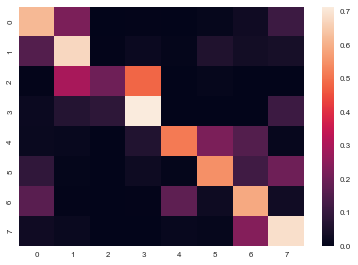

In [100]:
helper.evaluate(y_val, pred_mean)

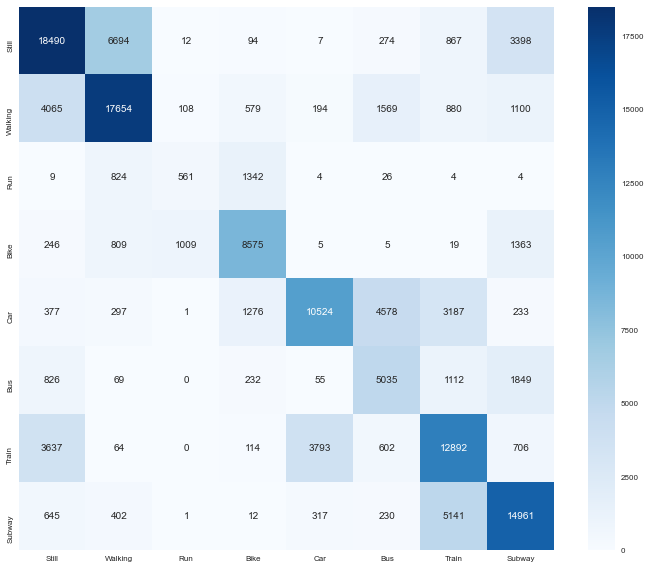

In [101]:
plot_box(y_val, pred_mean)

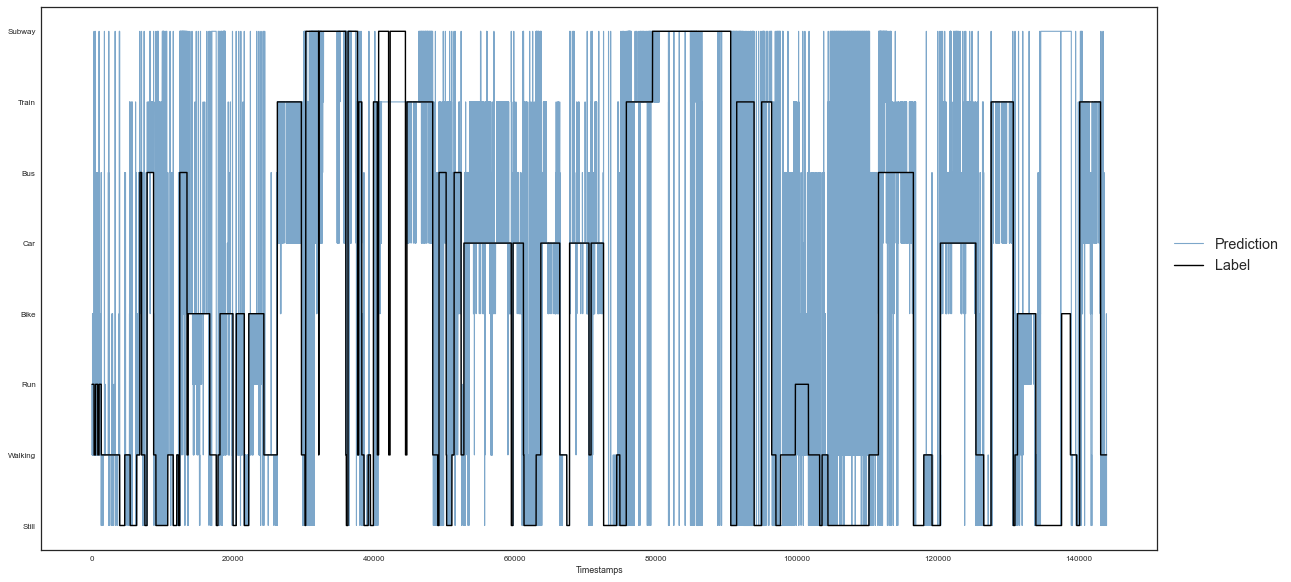

In [102]:
plot_prediction(y_val, pred_mean)

In [103]:
# helper.evaluate(y_val, pred_mean)

In [104]:
# Mean + add + argmax
pred_prob_rf_mean = pd.DataFrame(pred_prob_rf).rolling(window_size, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred_prob_bag_mean = pd.DataFrame(pred_prob_bag).rolling(window_size, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred_prob_lgb_mean = pd.DataFrame(pred_prob_lgb).rolling(window_size, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')

pred_prob_mean = pred_prob_rf_mean + pred_prob_bag_mean + pred_prob_lgb_mean
pred_mean2 = pd.Series(np.array(pred_prob_mean).argmax(axis = 1) + 1)

[[19168  6626     0    29    14    35   740  3224]
 [ 3025 19644     6    49   249  1485   682  1009]
 [    0  1040   426  1308     0     0     0     0]
 [  135   614   262  9775     0     0     0  1245]
 [  429   318     0   721 11201  4747  2998    59]
 [  886    23     0    24     0  5046  1088  2111]
 [ 3816    51     0    37  3799   253 13270   582]
 [  728   471     0     0   203   143  4652 15512]]
              precision    recall  f1-score   support

       Still       0.68      0.64      0.66     29836
     Walking       0.68      0.75      0.72     26149
         Run       0.61      0.15      0.25      2774
        Bike       0.82      0.81      0.82     12031
         Car       0.72      0.55      0.62     20473
         Bus       0.43      0.55      0.48      9178
       Train       0.57      0.61      0.59     21808
      Subway       0.65      0.71      0.68     21709

    accuracy                           0.65    143958
   macro avg       0.65      0.60      0.60    14

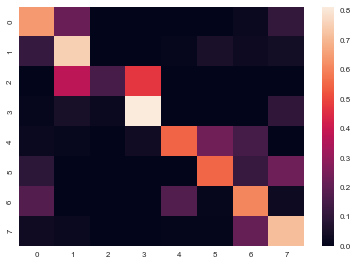

In [105]:
helper.evaluate(y_val, pred_mean2)

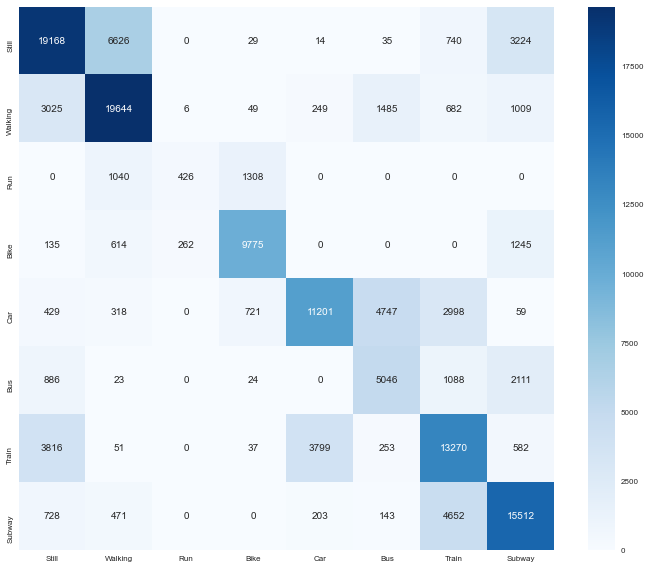

In [106]:
plot_box(y_val, pred_mean2)

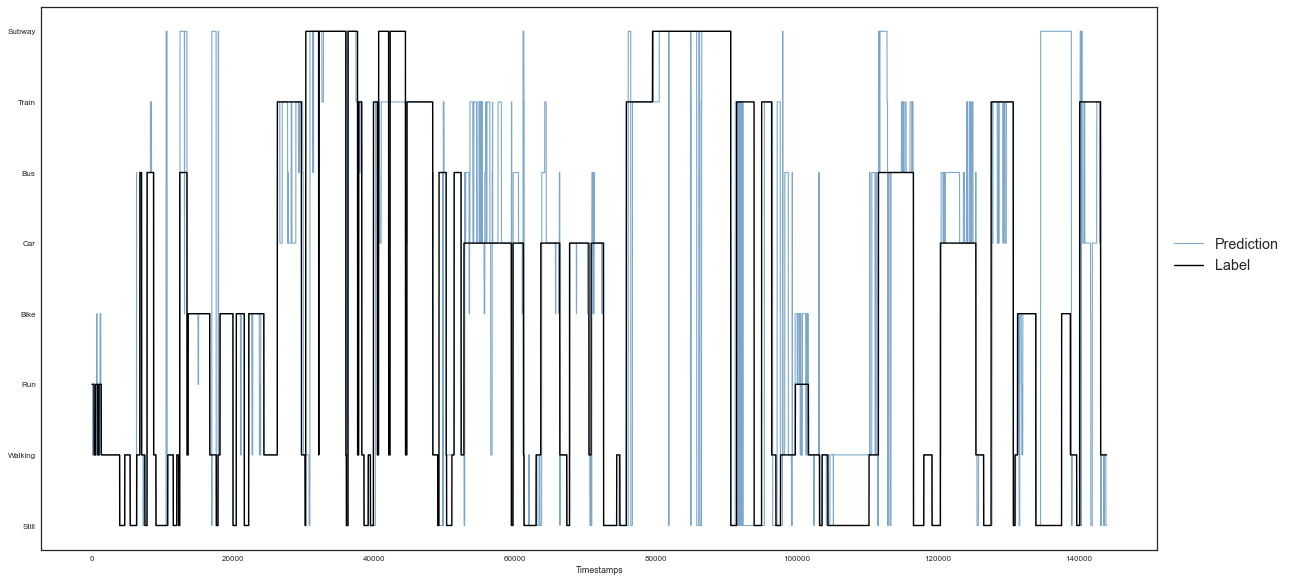

In [107]:
plot_prediction(y_val, pred_mean2)

## Rule-Based Method

- Duration Restriction
- Transition Banning

In [134]:
def get_group_conscount(sr):
    groups = groupby(sr.values.tolist())
    grouped_elements = [list(group) for key, group in groups]
    dur_df = pd.DataFrame({"label": [t[0] for t in grouped_elements],
                        "duration": [len(t) for t in grouped_elements]})
    return dur_df

In [135]:
df_dur = get_group_conscount(pred_mean2)
df_dur['cons_state_index'] = df_dur.index

In [136]:
df_res = pd.DataFrame({'pred': pred_mean2})
df_res['cons_state_index'] = (df_res['pred'].diff(1) != 0).astype('int').cumsum() - 1
df_res = pd.merge(df_res, df_dur, on = 'cons_state_index')

In [137]:
df_res['pred_last'] = df_res['pred'].shift(1).fillna(method = 'bfill').astype('int')

In [138]:
rule_time_dic = dict({1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5})

In [139]:
rule_trans_map = np.array(pd.read_table('data/transition_rule.txt', sep = ',', header = None))

In [140]:
pred_rule = df_res['pred'].copy()
for i in range(df_res.shape[0]):
    if df_res['duration'][i] < rule_time_dic[df_res['pred'][i]]:
        pred_rule[i] = df_res['pred_last'][i]
        df_res['pred_last'][i+1] = pred_rule[i]
    # transition rule
    # if rule_trans_map[df_res['pred_last'][i]-1, df_res['pred'][i]-1] == 0:
    #     pred_rule[i] = df_res['pred_last'][i]
    #     df_res['pred_last'][i+1] = pred_rule[i]

[[19098  6519     0    28    21   154   761  3255]
 [ 3046 19714     6    44   253  1384   694  1008]
 [    0  1151   435  1188     0     0     0     0]
 [  137   585   368  9696     0     0     0  1245]
 [  441   328     0   566 11130  4909  3038    61]
 [  856    28     0    17     0  5046  1114  2117]
 [ 3399    53     0    35  4225   243 13267   586]
 [  383   472     0     0  1982   100  3305 15467]]
              precision    recall  f1-score   support

       Still       0.70      0.64      0.67     29836
     Walking       0.68      0.75      0.72     26149
         Run       0.54      0.16      0.24      2774
        Bike       0.84      0.81      0.82     12031
         Car       0.63      0.54      0.58     20473
         Bus       0.43      0.55      0.48      9178
       Train       0.60      0.61      0.60     21808
      Subway       0.65      0.71      0.68     21709

    accuracy                           0.65    143958
   macro avg       0.63      0.60      0.60    14

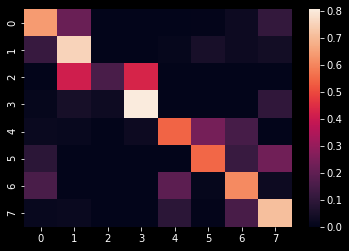

In [141]:
helper.evaluate(y_val, pred_rule)

In [142]:
df_dur2 = get_group_conscount(pred_rule)

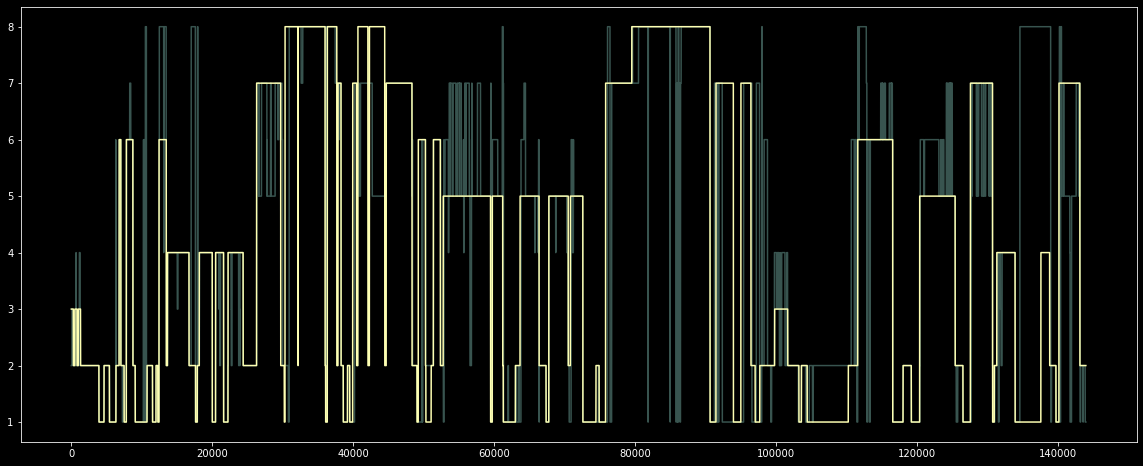

In [144]:
plot_prediction(y_val, pred_rule)

In [145]:
df_dur2.groupby('label').min()

,duration
label,
1,6
2,5
3,5
4,7
5,6
6,7
7,5
8,50


## Transition

In [173]:
tmp = np.zeros([8, 8])
for i, pair in enumerate(nltk.bigrams(data.df[data.df['valid_dlt'] == 1].label)):
    if pair[0] != pair[1]:
        tmp[pair[0]-1, pair[1]-1] += 1
tmp

array([[ 0., 23.,  4., 21.,  8., 45., 32., 23.],
       [60.,  0., 12., 21., 15., 15., 16., 22.],
       [ 8., 11.,  0.,  6.,  6.,  3.,  2.,  0.],
       [28., 23.,  5.,  0.,  6.,  2.,  4.,  0.],
       [ 8., 11.,  7.,  8.,  0.,  0.,  0.,  0.],
       [17., 42.,  7.,  2.,  0.,  0.,  0.,  0.],
       [17., 24.,  0.,  9.,  0.,  3.,  0.,  2.],
       [18., 27.,  1.,  0.,  0.,  0.,  1.,  0.]])

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 0]
 [1 1 1 1 1 0 0 0]
 [1 1 1 1 0 1 0 0]
 [1 1 0 1 0 1 1 1]
 [1 1 1 0 0 0 1 1]]


<AxesSubplot:>

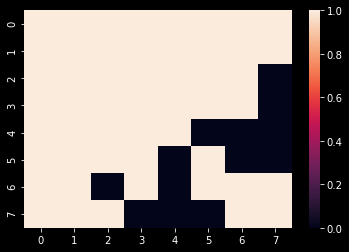

In [215]:
tmp = np.zeros([8, 8])
for i, pair in enumerate(nltk.bigrams(data.df[data.df['valid_dlt'] == 1].label)):
    if pair[0] != pair[1]:
        tmp[pair[0]-1, pair[1]-1] += 1
tmp = 1-(tmp == 0).astype('int') + np.diag([1]*8)
print(tmp)
sns.heatmap(tmp)

<AxesSubplot:>

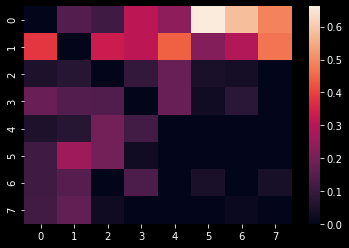

In [146]:
sns.heatmap(tmp / tmp.sum(axis = 1)) # axis = 1 求行和

In [112]:
# plt.figure(figsize = [12, 6])
# sns.boxplot(x = df_dur['label'], y = df_dur['duration'])